In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import pickle
import json
from tensorflow.keras.applications.resnet import preprocess_input
import boto3
from botocore.exceptions import ClientError
from tensorflow.keras.models import load_model


def _load_model(model_path="converted_model"):
        """Load the fashion classification model and components."""
        model = tf.saved_model.load(model_path)        
        with open(os.path.join(model_path, 'label_binarizers_fixed.pkl'), 'rb') as f:
            label_binarizers = pickle.load(f)
            
        with open(os.path.join(model_path, 'num_classes.json'), 'r') as f:
            num_classes = json.load(f)
            
        return model, label_binarizers, num_classes
    
def load_fashion_metadata(csv_path):
    """
    Load fashion metadata from CSV file
    """
    return pd.read_csv(csv_path)

def create_complementary_mapping():
    """
    Create a mapping of which categories complement each other
    Returns a dictionary with category as key and list of complementary categories as value
    """
    complementary_mapping = {
        'Topwear': ['Bottomwear', 'Footwear', 'Watches', 'Accessories'],
        'Bottomwear': ['Topwear', 'Footwear', 'Watches', 'Accessories'],
        'Footwear': ['Topwear', 'Bottomwear', 'Watches', 'Accessories'],
        'Watches': ['Topwear', 'Bottomwear', 'Footwear'],
        'Accessories': ['Topwear', 'Bottomwear', 'Footwear']
    }
    return complementary_mapping

def generate_presigned_url(bucket_name, object_name, expiration=3600):
    """Generate a presigned URL to access S3 object"""
    s3_client = boto3.client('s3')
    try:
        response = s3_client.generate_presigned_url('get_object',
                                                    Params={'Bucket': bucket_name,
                                                            'Key': f"images/{object_name}"},
                                                    ExpiresIn=expiration)
    except ClientError as e:
        print(f"Error generating presigned URL: {e}")
        return None
    return response

def enhance_with_image_urls(recommendations, image_bucket_name):
    """Add image URLs to recommendations"""
    for category, items in recommendations.items():
        for item in items:
            image_id = str(item['id'])
            image_key = f"{image_id}.jpg"  
            item['image_url'] = generate_presigned_url(image_bucket_name, image_key)
    return recommendations

def create_style_compatibility_rules():
    """
    Define compatibility rules for different styles
    Returns a dictionary with (category, usage) as key and compatible attributes as value
    """
    compatibility_rules = {
        ('Topwear', 'Casual'): {
            'compatible_colors': ['Blue', 'Black', 'Grey', 'White', 'Beige', 'Navy Blue'],
            'compatible_seasons': ['Summer', 'Spring', 'Fall'],
        },
        ('Topwear', 'Formal'): {
            'compatible_colors': ['White', 'Light Blue', 'Grey', 'Black', 'Navy Blue'],
            'compatible_seasons': ['All'],
        },
        ('Bottomwear', 'Casual'): {
            'compatible_colors': ['Blue', 'Black', 'Beige', 'Grey'],
            'compatible_seasons': ['Summer', 'Spring', 'Fall'],
        },
        ('Bottomwear', 'Formal'): {
            'compatible_colors': ['Black', 'Navy Blue', 'Grey', 'Beige'],
            'compatible_seasons': ['All'],
        },
        ('Footwear', 'Casual'): {
            'compatible_colors': ['White', 'Black', 'Brown', 'Blue'],
            'compatible_seasons': ['All'],
        },
        ('Footwear', 'Formal'): {
            'compatible_colors': ['Black', 'Brown'],
            'compatible_seasons': ['All'],
        }
    }
    return compatibility_rules

def get_fashion_recommendations(input_metadata, model_dir, num_recommendations=3):
    """
    Get fashion recommendations based on input metadata
    
    Args:
        input_metadata: Dictionary containing metadata of the input item
        metadata_df: DataFrame containing metadata of all items
        num_recommendations: Number of recommendations to return per category
        
    Returns:
        Dictionary with category as key and list of recommended items as value
    """
    metadata_df = model_dir
    
    input_gender = input_metadata.get('gender', '')
    input_category = input_metadata.get('subCategory', '')
    input_color = input_metadata.get('baseColour', '')
    input_season = input_metadata.get('season', '')
    input_usage = input_metadata.get('usage', '')
    
    complementary_mapping = {
        'Shoes': ['Topwear', 'Bottomwear', 'Watches', 'Accessories', 'Belts'],
        
        'Topwear': ['Bottomwear', 'Shoes', 'Watches', 'Belts', 'Accessories'],
        
        'Bottomwear': ['Topwear', 'Shoes', 'Watches', 'Belts', 'Accessories'],
        
        'Watches': ['Topwear', 'Bottomwear', 'Shoes'],
        
        'Sandal': ['Topwear', 'Bottomwear', 'Watches', 'Accessories'],
        'Flip Flops': ['Topwear', 'Bottomwear', 'Watches', 'Accessories'],
    }
    
    complementary_categories = complementary_mapping.get(input_category, [])
    

    if not complementary_categories:
        if input_category in ['Topwear', 'Bottomwear', 'Shoes', 'Sandal', 'Flip Flops']:
            complementary_categories = ['Topwear', 'Bottomwear', 'Shoes', 'Watches', 'Belts']
        else:
            complementary_categories = ['Topwear', 'Bottomwear', 'Shoes']
    
    if input_category in complementary_categories:
        complementary_categories.remove(input_category)
    
    
    color_compatibility = {
        'Red': ['Black', 'White', 'Grey', 'Blue', 'Navy Blue', 'Beige'],
        'Blue': ['White', 'Grey', 'Black', 'Beige', 'Navy Blue', 'Red'],
        'Black': ['White', 'Grey', 'Red', 'Blue', 'Green', 'Yellow', 'Pink', 'Purple'],
        'White': ['Black', 'Blue', 'Red', 'Grey', 'Navy Blue', 'Green', 'Purple'],
        'Grey': ['Black', 'White', 'Blue', 'Red', 'Navy Blue'],
        'Navy Blue': ['White', 'Grey', 'Red', 'Beige'],
        'Green': ['White', 'Black', 'Beige', 'Grey'],
        'Beige': ['Navy Blue', 'Blue', 'Brown', 'Black', 'White', 'Red'],
        'Brown': ['Beige', 'White', 'Blue', 'Green'],
        'Yellow': ['Black', 'Blue', 'White'],
        'Pink': ['Black', 'White', 'Grey', 'Navy Blue'],
        'Purple': ['White', 'Black', 'Grey']
    }
    
    
    compatible_colors = color_compatibility.get(input_color, [])

    if not compatible_colors:
        compatible_colors = ['Black', 'White', 'Grey', 'Navy Blue', 'Blue', 'Beige']
    
    if input_color not in compatible_colors:
        compatible_colors.append(input_color)
    
    filtered_df = metadata_df[metadata_df['gender'] == input_gender]
    
    recommendations = {}
    
    for category in complementary_categories:
        category_df = filtered_df[filtered_df['subCategory'] == category]
        
        if len(category_df) == 0:
            continue
        
        color_filter = category_df['baseColour'].isin(compatible_colors)
        season_filter = category_df['season'] == input_season
        usage_filter = category_df['usage'] == input_usage
        
       
        matching_items = category_df[season_filter & usage_filter & color_filter]
        
        if len(matching_items) < num_recommendations:
            matching_items = category_df[season_filter & color_filter]
        
        if len(matching_items) < num_recommendations:
            matching_items = category_df[usage_filter & color_filter]
        
        if len(matching_items) < num_recommendations:
            matching_items = category_df[color_filter]
        
        if len(matching_items) < num_recommendations:
            matching_items = category_df
        
        if len(matching_items) > 0:
            recommendations[category] = matching_items.head(num_recommendations).to_dict('records')
    
    return recommendations
def predict_and_recommend(image_path, model, label_binarizers, metadata_csv_path, num_recommendations=3):
    """Updated end-to-end prediction with SavedModel compatibility"""
    image = load_image(image_path)
    
    predictions = predict_fashion_item(model, label_binarizers, image)
    
    input_metadata = {
        'gender': predictions['gender']['label'],
        'subCategory': predictions['subCategory']['label'],
        'baseColour': predictions['color']['label'],
        'season': predictions['season']['label'],
        'usage': predictions['usage']['label']
    }
    
    metadata_df = load_fashion_metadata(metadata_csv_path)
    recommendations = get_fashion_recommendations(input_metadata, metadata_df, num_recommendations)
    
    return input_metadata, recommendations
def load_image(imagePath):
    """Load and preprocess image"""
    IMAGE_DIMS = (180, 180, 3)
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    return image
def predict_fashion_item(model, label_binarizers, image_array):
    """Make predictions using SavedModel format"""
    input_tensor = tf.convert_to_tensor(image_array[np.newaxis, ...], dtype=tf.float32)
    
    infer = model.signatures["serving_default"]
    predictions = infer(input_tensor)
    

    predictions_dict = {}
    for category, lb in label_binarizers.items():
        output_name = f"{category}_output"
        probs = predictions[output_name].numpy()[0]
        label_idx = np.argmax(probs)
        
        predictions_dict[category] = {
            'label': lb.classes_[label_idx],
            'confidence': float(probs[label_idx])
        }
    
    return predictions_dict

In [2]:
def visualize_recommendations(recommendations, images_dir='images', figsize=(15, 10)):
    """
    Visualize the recommended fashion items using matplotlib.
    
    Args:
        recommendations: Dictionary with category as key and list of recommended items as value
        images_dir: Directory containing the images (default: 'images')
        figsize: Size of the figure (default: (15, 10))
        
    Returns:
        None (displays the visualizations)
    """
    import matplotlib.pyplot as plt
    import cv2
    import os
    from matplotlib.gridspec import GridSpec
    
    # Count total number of items to display
    total_items = sum(len(items) for items in recommendations.values())
    if total_items == 0:
        print("No recommendations to display.")
        return
    
    # Calculate grid dimensions based on categories and items
    num_categories = len(recommendations)
    
    # Create figure and GridSpec
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(num_categories, max(len(items) for category, items in recommendations.items()) + 1)
    
    # Plot each category
    for i, (category, items) in enumerate(recommendations.items()):
        # Plot category name in the first column
        ax = fig.add_subplot(gs[i, 0])
        ax.text(0.5, 0.5, f"{category}", ha='center', va='center', fontsize=12, fontweight='bold')
        ax.axis('off')
        
        # Plot items in this category
        for j, item in enumerate(items):
            image_id = str(item['id'])
            image_path = os.path.join(images_dir, f"{image_id}.jpg")
            
            if os.path.exists(image_path):
                # Load and display image
                ax = fig.add_subplot(gs[i, j+1])
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img)
                
                item_info = f"ID: {item['id']}\n"
                item_info += f"Color: {item.get('baseColour', 'N/A')}\n"
                item_info += f"Usage: {item.get('usage', 'N/A')}"
                ax.set_xlabel(item_info, fontsize=8)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax = fig.add_subplot(gs[i, j+1])
                ax.text(0.5, 0.5, f"Image not found\nID: {image_id}", ha='center', va='center')
                ax.axis('off')
    
    plt.tight_layout()
    plt.suptitle("Fashion Recommendations", fontsize=16, y=1.02)
    plt.show()

def visualize_input_with_recommendations(input_metadata, input_image_path, recommendations, images_dir='images', figsize=(18, 12)):
    """
    Visualize the input item alongside its recommendations.
    
    Args:
        input_metadata: Dictionary containing metadata of the input item
        input_image_path: Path to the input image
        recommendations: Dictionary with category as key and list of recommended items as value
        images_dir: Directory containing the images (default: 'images')
        figsize: Size of the figure (default: (18, 12))
        
    Returns:
        None (displays the visualizations)
    """
    import matplotlib.pyplot as plt
    import cv2
    import os
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=figsize)
    
    num_categories = len(recommendations)
    
    gs = GridSpec(num_categories + 1, 4)
    
    ax_input = fig.add_subplot(gs[0, :2])
    if os.path.exists(input_image_path):
        img = cv2.imread(input_image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax_input.imshow(img)
    else:
        ax_input.text(0.5, 0.5, "Input image not found", ha='center', va='center')
        ax_input.axis('off')
    
    ax_input.set_title("Input Item", fontsize=12, fontweight='bold')
    ax_input.set_xticks([])
    ax_input.set_yticks([])
    
    ax_meta = fig.add_subplot(gs[0, 2:])
    metadata_text = "\n".join([f"{key}: {value}" for key, value in input_metadata.items()])
    ax_meta.text(0.1, 0.5, f"Metadata:\n\n{metadata_text}", va='center', fontsize=10)
    ax_meta.axis('off')
    
    row = 1
    for category, items in recommendations.items():
        ax_category = fig.add_subplot(gs[row, 0])
        ax_category.text(0.5, 0.5, category, ha='center', va='center', fontsize=12, fontweight='bold')
        ax_category.axis('off')
        
        for j, item in enumerate(items[:3]):
            image_id = str(item['id'])
            image_path = os.path.join(images_dir, f"{image_id}.jpg")
            
            ax = fig.add_subplot(gs[row, j+1])
            if os.path.exists(image_path):
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img)
                
                item_info = f"ID: {item['id']}\n"
                if 'baseColour' in item:
                    item_info += f"Color: {item['baseColour']}\n"
                if 'usage' in item:
                    item_info += f"Usage: {item['usage']}"
                ax.set_xlabel(item_info, fontsize=8)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.text(0.5, 0.5, f"Image not found\nID: {image_id}", ha='center', va='center')
                ax.axis('off')
        
        row += 1
    
    plt.tight_layout()
    plt.suptitle("Fashion Item with Complementary Recommendations", fontsize=16, y=1.02)
    plt.show()

def create_recommendation_collage(recommendations, input_metadata=None, input_image_path=None, 
                                  images_dir='images', output_path=None, figsize=(15, 10), dpi=100):
    """
    Create a collage of recommended fashion items and optionally save it to disk.
    
    Args:
        recommendations: Dictionary with category as key and list of recommended items as value
        input_metadata: Optional metadata of the input item
        input_image_path: Optional path to the input image
        images_dir: Directory containing the images (default: 'images')
        output_path: Path to save the collage image (default: None, just display)
        figsize: Size of the figure (default: (15, 10))
        dpi: Resolution of the output image (default: 100)
        
    Returns:
        None (displays and optionally saves the visualizations)
    """
    import matplotlib.pyplot as plt
    import cv2
    import os
    import numpy as np
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=figsize)
    
    has_input = input_metadata is not None and input_image_path is not None
    
    num_categories = len(recommendations)
    
    if has_input:
        gs = GridSpec(num_categories + 1, 4)
        
        ax_input = fig.add_subplot(gs[0, :2])
        if os.path.exists(input_image_path):
            img = cv2.imread(input_image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax_input.imshow(img)
        else:
            ax_input.text(0.5, 0.5, "Input image not found", ha='center', va='center')
            ax_input.axis('off')
        
        ax_input.set_title("Input Item", fontsize=12, fontweight='bold')
        ax_input.set_xticks([])
        ax_input.set_yticks([])
        
        ax_meta = fig.add_subplot(gs[0, 2:])
        metadata_text = "\n".join([f"{key}: {value}" for key, value in input_metadata.items()])
        ax_meta.text(0.1, 0.5, f"Metadata:\n\n{metadata_text}", va='center', fontsize=10)
        ax_meta.axis('off')
        
        start_row = 1
    else:
        gs = GridSpec(num_categories, 4)
        start_row = 0
    
    row = start_row
    for category, items in recommendations.items():
        ax_category = fig.add_subplot(gs[row, 0])
        ax_category.text(0.5, 0.5, category, ha='center', va='center', fontsize=12, fontweight='bold')
        ax_category.axis('off')
        
        for j, item in enumerate(items[:3]):
            image_id = str(item['id'])
            image_path = os.path.join(images_dir, f"{image_id}.jpg")
            
            ax = fig.add_subplot(gs[row, j+1])
            if os.path.exists(image_path):
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img)
                
                item_info = f"ID: {item['id']}\n"
                if 'baseColour' in item:
                    item_info += f"Color: {item['baseColour']}\n"
                if 'usage' in item:
                    item_info += f"Usage: {item['usage']}"
                ax.set_xlabel(item_info, fontsize=8)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.text(0.5, 0.5, f"Image not found\nID: {image_id}", ha='center', va='center')
                ax.axis('off')
        
        row += 1
    
    plt.tight_layout()
    title = "Fashion Item with Complementary Recommendations" if has_input else "Fashion Recommendations"
    plt.suptitle(title, fontsize=16, y=1.02)
    
    if output_path:
        plt.savefig(output_path, dpi=dpi, bbox_inches='tight')
        print(f"Collage saved to {output_path}")
    
    plt.show()

C:\Users\shiva\anaconda\envs\ortools_env\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


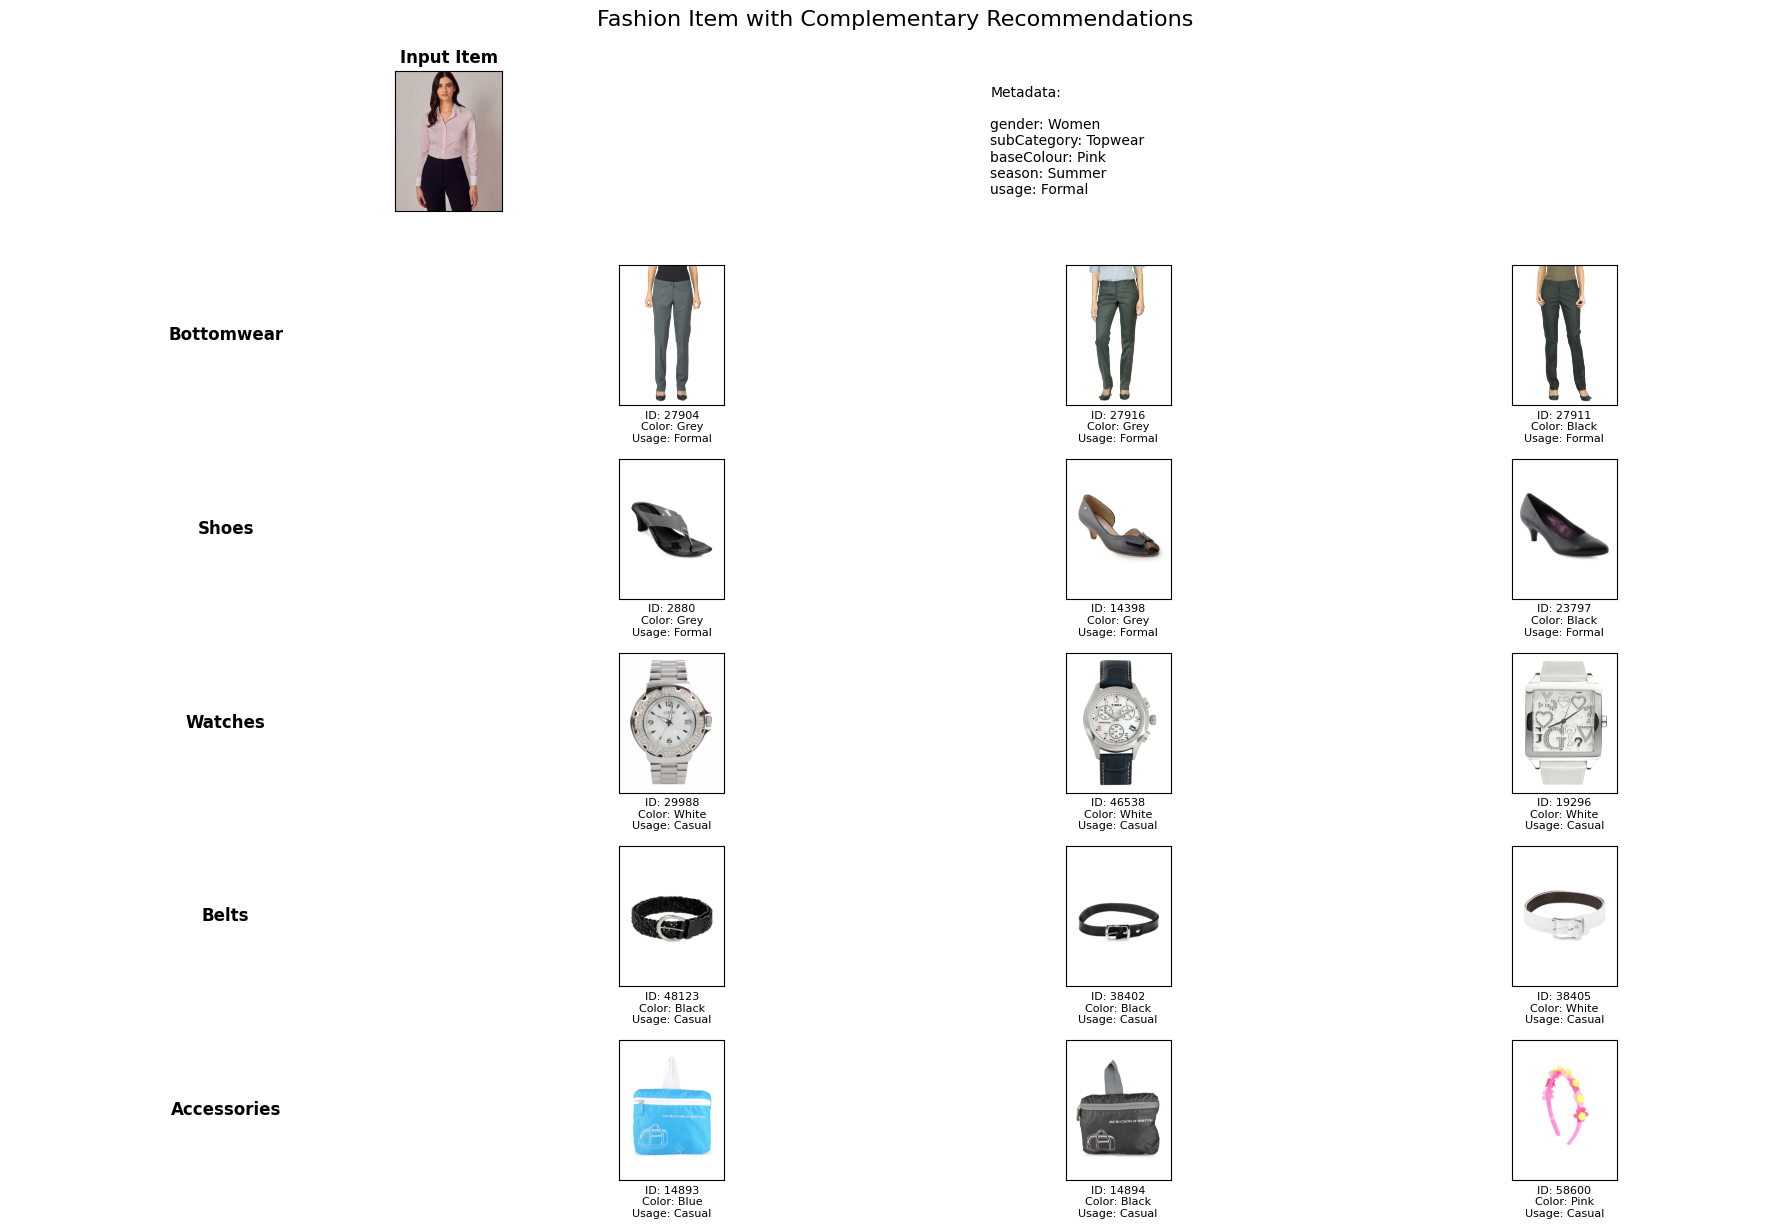

In [5]:
model, label_binarizers, num_classes_dict = _load_model()
IMAGES_PATH = "images"
input_image_path = "abc.jpeg"
image = load_image(input_image_path)
predictions = predict_fashion_item(model, label_binarizers, image)
styles_df=pd.read_csv('styles.csv',on_bad_lines="skip")
styles_df = styles_df.dropna()
columns_to_drop = ['year', 'productDisplayName', 'masterCategory', 'articleType']
existing_columns = [col for col in columns_to_drop if col in styles_df.columns]
styles_df.drop(columns=existing_columns, inplace=True)
selected_metadata = styles_df[styles_df['id'].isin([int(i.split('.')[0]) for i in os.listdir(IMAGES_PATH)])]


input_metadata = {
    'gender': predictions['gender']['label'],
    'subCategory': predictions['subCategory']['label'],
    'baseColour': predictions['color']['label'],
    'season': predictions['season']['label'],
    'usage': predictions['usage']['label']
}

recommendations = get_fashion_recommendations(input_metadata,selected_metadata)

visualize_input_with_recommendations(input_metadata, input_image_path, recommendations)



In [4]:
# input_image_path = "OIP (2).jpg"
# image = load_image(input_image_path)
# predictions = predict_fashion_item(model, label_binarizers, image)
# selected_metadata=pd.read_csv('selected_metadata.csv')
# input_metadata = {
#     'gender': predictions['gender']['label'],
#     'subCategory': predictions['subCategory']['label'],
#     'baseColour': predictions['color']['label'],
#     'season': predictions['season']['label'],
#     'usage': predictions['usage']['label']
# }

# recommendations = get_fashion_recommendations(input_metadata,selected_metadata)

# visualize_input_with_recommendations(input_metadata, input_image_path, recommendations)

In [5]:
# input_image_path = "aaa.jpg"
# image = load_image(input_image_path)
# predictions = predict_fashion_item(model, label_binarizers, image)
# selected_metadata=pd.read_csv('selected_metadata.csv',on_bad_lines="skip")
# input_metadata = {
#     'gender': predictions['gender']['label'],
#     'subCategory': predictions['subCategory']['label'],
#     'baseColour': predictions['color']['label'],
#     'season': predictions['season']['label'],
#     'usage': predictions['usage']['label']
# }

# recommendations = get_fashion_recommendations(input_metadata,selected_metadata)

# visualize_input_with_recommendations(input_metadata, input_image_path, recommendations)